In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.cluster import KMeans
import xarray as xr
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Converting the sliding scale to look at months instead of years

In [2]:
# Load the datasets
osc_data_monthly = xr.open_dataset('data_use/osc_idx.nc').to_dataframe()
GL_data = xr.open_dataset('data_use/GL_NCEP_gridded_air.nc')

#getting y labels:

#getting months of data
months = np.asarray(pd.to_datetime(GL_data.time).month)

#getting years
years = GL_data.groupby('time.year').mean().year[1:]

#getting only winter months (DJF), leaving out 1950
GL_winter = GL_data.air[np.where((months == 12) | (months == 1) | (months == 2))][2:]

#averaging annually, converting to numpy
GL_DJF = np.zeros((72, 5, 9))
for i in np.arange(72):
    GL_DJF[i] = GL_winter[3*i:3*(i+1)].mean('time').to_numpy()
    
#creating new DataArray
GL_DJF = xr.DataArray(
    data = GL_DJF,
    dims = ['year', 'lat', 'lon'],
    coords = dict(
        year = years,
        lat = GL_data.lat,
        lon = GL_data.lon
    )
)

#standardizing data
scaler = StandardScaler()
GL_DJF_stan = scaler.fit_transform(GL_DJF.to_numpy().reshape(72, 45))

#using KMeans with 2 clusters
kmeans2 = KMeans(n_clusters = 2, random_state = 42, n_init = 'auto')
kmeans2.fit(GL_DJF_stan)
y_labels = kmeans2.labels_
y_clusters2 = np.copy(y_labels)[1:]

In [3]:
#using KMeans with 3 clusters
kmeans3 = KMeans(n_clusters = 3, random_state = 42, n_init = 'auto')
kmeans3.fit(GL_DJF_stan)
y_labels3 = kmeans3.labels_
y_clusters3 = np.copy(y_labels3)

#Align `y_clusters3` with `X_lagged`
y_clusters3 = y_labels3[1:]

In [4]:
# Creating a lagged dataset: The inputs will be the oscillation indices lagged up to 24 months
#creating lagged column names
lagged_cols = []
for i in np.arange(len(osc_data_monthly.columns)):
    for j in np.arange(12):
        lagged_cols.append(f'{osc_data_monthly.columns[i]}_lag{j}')

#lagging data
lagged_data = np.zeros((71, len(lagged_cols)))
for i in np.arange(71):
    for j in np.arange(10):
        lagged_data[i,12*j:12*(j+1)] = np.flip(osc_data_monthly[osc_data_monthly.columns[j]][12*i:(12*i + 12)].to_numpy())
#putting into a DataFrame
lagged_DF = pd.DataFrame(
    data = lagged_data,
    index = np.arange(1951, 2022),
    columns = lagged_cols
)

#standardizing
X_lagged = StandardScaler().fit_transform(lagged_DF)

#Align `y_clusters` with `X_lagged`
y_clusters = y_labels[1:]

In [5]:
#function to get metrics for models
def get_model_score(model, y_clusters, metric):
    #training size is 4 times testing size
    n_test = np.arange(2,10)
    n_train = 4*n_test
    
    #list for metrics
    results = []
    
    #looping throuhg different training and testing sizes
    for i in np.arange(len(n_test)):
        #using a sliding window: training will be first n_train data, then testing will be next n_ttest data
        overall_scores = []
        for start_idx in range(len(X_lagged) - n_train[i] - n_test[i]):
            #getting training and testing data
            X_train = X_lagged[start_idx:start_idx + n_train[i]]
            y_train = y_clusters[start_idx:start_idx + n_train[i]]
            X_test = X_lagged[start_idx + n_train[i]: start_idx + n_test[i] + n_train[i]]
            y_test = y_clusters[start_idx + n_train[i]: start_idx + n_test[i] + n_train[i]]
            
            #fitting model and making predictions
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            #getting metric and appending to results
            score = metric(y_test, y_pred)
            overall_scores.append(score)
        results.append(np.mean(overall_scores))
        
    return np.asarray(results)

In [6]:
#getting accuracy for 7 models
accuracy_LogReg = get_model_score(LogisticRegression(),y_clusters3, accuracy_score)
accuracy_HGBC = get_model_score(HistGradientBoostingClassifier(max_iter=200, random_state=42, learning_rate=0.001, class_weight='balanced'),y_clusters3, accuracy_score)
accuracy_Bagging = get_model_score(BaggingClassifier(), y_clusters3, accuracy_score)
accuracy_RandForest = get_model_score(RandomForestClassifier(), y_clusters3, accuracy_score)
accuracy_Ridge = get_model_score(RidgeClassifier(), y_clusters3, accuracy_score)
accuracy_Lasso = get_model_score(LogisticRegression(penalty='l1', solver='saga', max_iter=5000), y_clusters3, accuracy_score)
accuracy_Tree = get_model_score(DecisionTreeClassifier(max_depth=3), y_clusters3, accuracy_score)

In [7]:
#function to get metrics for null model
def get_null_score(y_clusters, metric):
    n_test = np.arange(2,10)
    n_train = 4*n_test
    
    results = []
    for i in np.arange(len(n_test)):
        overall_scores = []
        for start_idx in range(len(X_lagged) - n_train[i] - n_test[i]):
            X_train = X_lagged[start_idx:start_idx + n_train[i]]
            y_train = y_clusters[start_idx:start_idx + n_train[i]]
            X_test = X_lagged[start_idx + n_train[i]: start_idx + n_test[i] + n_train[i]]
            y_test = y_clusters[start_idx + n_train[i]: start_idx + n_test[i] + n_train[i]]
            
            #using most frequent class in training dataset
            most_freq = np.argmax(np.bincount(y_train))
            y_pred = most_freq*np.ones_like(y_test)

            score = metric(y_test, y_pred)
            overall_scores.append(score)
        results.append(np.mean(overall_scores))
        
    return np.asarray(results)

In [9]:
#getting null scores
null_accuracy = get_null_score(y_clusters3, accuracy_score)

In [10]:
n_test = np.arange(2,10)
n_train = 4*n_test

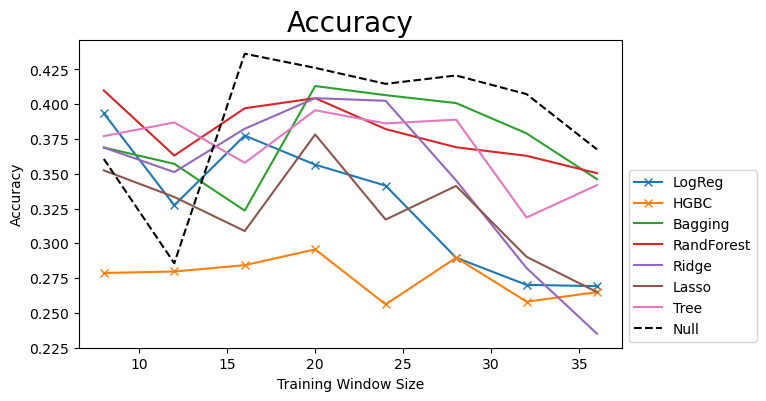

In [17]:
#plotting
fig, ax = plt.subplots(figsize = (7,4))
ax.plot(n_train, accuracy_LogReg, label = 'LogReg', marker = 'x')
ax.plot(n_train, accuracy_HGBC, label = 'HGBC', marker = 'x')
ax.plot(n_train, accuracy_Bagging, label = 'Bagging')
ax.plot(n_train, accuracy_RandForest, label = 'RandForest')
ax.plot(n_train, accuracy_Ridge, label = 'Ridge')
ax.plot(n_train, accuracy_Lasso, label = 'Lasso')
ax.plot(n_train, accuracy_Tree, label = 'Tree')
ax.plot(n_train, null_accuracy, c = 'k', ls = '--', label = 'Null')
ax.legend(bbox_to_anchor = (1,.6))
ax.set_xlabel('Training Window Size')
ax.set_ylabel('Accuracy')
#ax.set_ylim(0,1)
ax.set_title('Accuracy', fontsize = 20)
plt.savefig('report_figures/3cluster_accuracy.png')

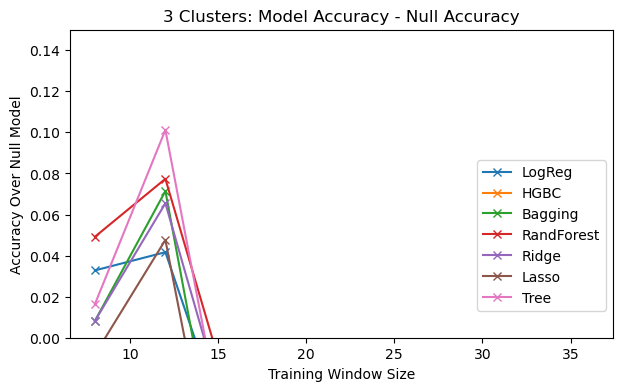

In [15]:
#plotting
fig, ax = plt.subplots(figsize = (7,4))
ax.plot(n_train, accuracy_LogReg - null_accuracy, label = 'LogReg', marker = 'x')
ax.plot(n_train, accuracy_HGBC - null_accuracy, label = 'HGBC', marker = 'x')
ax.plot(n_train, accuracy_Bagging - null_accuracy, label = 'Bagging', marker = 'x')
ax.plot(n_train, accuracy_RandForest - null_accuracy, label = 'RandForest', marker = 'x')
ax.plot(n_train, accuracy_Ridge - null_accuracy, label = 'Ridge', marker = 'x')
ax.plot(n_train, accuracy_Lasso - null_accuracy, label = 'Lasso', marker = 'x')
ax.plot(n_train, accuracy_Tree - null_accuracy, label = 'Tree', marker = 'x')
ax.legend(bbox_to_anchor = (1,.6))
ax.set_xlabel('Training Window Size')
ax.set_ylabel('Accuracy Over Null Model')
ax.set_ylim(0,.15)
ax.set_title('3 Clusters: Model Accuracy - Null Accuracy')
plt.savefig('report_figures/3cluster_accuracy.png')